In [ ]:
import os
from pathlib import Path


# Navigate to the project root directory (where .git is)
def find_git_root(path="."):
    path = Path(path).resolve()
    for parent in [path] + list(path.parents):
        if (parent / ".git").exists():
            return parent
    return path  # fallback if .git not found


project_root = find_git_root()
os.chdir(project_root)
print(f"Working directory set to: {project_root}")

Working directory set to: /Users/sherman/GitHub/ISYE-6740/Final Project/Workspace


In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mlxtend.frequent_patterns import association_rules, fpgrowth
from mlxtend.preprocessing import TransactionEncoder

pd.set_option("display.max_columns", 50)

In [ ]:
transaction_data = pd.read_parquet(
    "data/processed/master_dataset.parquet",
    columns=["CustomerID", "ProductName", "CategoryName", "Class"],
)

cluster_data = pd.read_parquet("data/processed/clustered_customer_gmm.parquet")

display(transaction_data.head())
print(f"Transaction data shape: {transaction_data.shape}")

display(cluster_data.head())
print(f"Cluster data shape: {cluster_data.shape}")

,CustomerID,ProductName,CategoryName,Class
0,27039,Vaccum Bag 10x13,Confections,High
1,25011,Sardines,Grain,Low
2,94024,Crab - Imitation Flakes,Produce,Medium
3,73966,Smirnoff Green Apple Twist,Seafood,High
4,32653,Coffee - Dark Roast,Poultry,Low


Transaction data shape: (6758125, 4)


,CustomerID,cluster_label
0,1,2
1,2,2
2,3,2
3,4,2
4,5,2


Cluster data shape: (98759, 2)


In [ ]:
transaction_data["CustomerID"] = transaction_data["CustomerID"].astype(str)
cluster_data["CustomerID"] = cluster_data["CustomerID"].astype(str)

In [ ]:
df = pd.merge(
    transaction_data,
    cluster_data,
    on="CustomerID",
    how="left",
    validate="m:1",
)

df.head()

,CustomerID,ProductName,CategoryName,Class,cluster_label
0,27039,Vaccum Bag 10x13,Confections,High,1
1,25011,Sardines,Grain,Low,1
2,94024,Crab - Imitation Flakes,Produce,Medium,2
3,73966,Smirnoff Green Apple Twist,Seafood,High,2
4,32653,Coffee - Dark Roast,Poultry,Low,1


In [ ]:
# Set a reproducible random state
RANDOM_STATE = 42

In [ ]:
# Container for rules per cluster
cluster_rules = {}

# Loop through each unique cluster
for cluster_id in df["cluster_label"].unique():
    print(f"\n Processing Cluster: {cluster_id}")

    # Filter data for this cluster
    cluster_df = df[df["cluster_label"] == cluster_id]

    sampled_customers = (
        cluster_df["CustomerID"]
        .drop_duplicates()
        .sample(n=3500, random_state=RANDOM_STATE)
    )

    sampled_df = cluster_df[cluster_df["CustomerID"].isin(sampled_customers)]

    # Create basket: group by CustomerID → list of ProductNames
    baskets = sampled_df.groupby("CustomerID")["ProductName"].apply(list).tolist()

    # One-hot encode
    te = TransactionEncoder()
    te_matrix = te.fit(baskets).transform(baskets)
    df_encoded = pd.DataFrame(te_matrix, columns=te.columns_)

    # Find frequent itemsets
    frequent_items = fpgrowth(
        df_encoded,
        use_colnames=True,
        min_support=0.02,
    )

    # Generate association rules
    rules = association_rules(frequent_items, metric="lift", min_threshold=1)
    rules["cluster"] = cluster_id

    cluster_rules[cluster_id] = rules


 Processing Cluster: 1

 Processing Cluster: 2

 Processing Cluster: 3

 Processing Cluster: 0


In [ ]:
result_rules = (
    pd.concat(cluster_rules.values(), ignore_index=True)
    .sort_values(by=["lift", "confidence", "cluster"], ascending=[False, False, True])
    .reset_index(drop=True)
)

result_rules["antecedents"] = result_rules["antecedents"].apply(list)
result_rules["consequents"] = result_rules["consequents"].apply(list)

result_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,cluster
0,[Papayas],"[Pepper - Paprika, Hungarian]",0.121143,0.124571,0.023714,0.195755,1.571425,1.0,0.008623,1.088509,0.413759,0.106821,0.081313,0.193061,0
1,"[Pepper - Paprika, Hungarian]",[Papayas],0.124571,0.121143,0.023714,0.190367,1.571425,1.0,0.008623,1.085501,0.415380,0.106821,0.078766,0.193061,0
2,[Soup - Campbells Tomato Ravioli],"[Pork - Bacon, Double Smoked]",0.134286,0.139143,0.028857,0.214894,1.544410,1.0,0.010172,1.096485,0.407182,0.117991,0.087995,0.211143,2
3,"[Pork - Bacon, Double Smoked]",[Soup - Campbells Tomato Ravioli],0.139143,0.134286,0.028857,0.207392,1.544410,1.0,0.010172,1.092235,0.409480,0.117991,0.084446,0.211143,2
4,[Flour - Teff],[Pop Shoppe Cream Soda],0.121143,0.122286,0.022571,0.186321,1.523651,1.0,0.007757,1.078698,0.391055,0.102199,0.072957,0.185450,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271261,[Pate - Cognac],"[Beef - Ground, Extra Lean, Fresh]",0.142857,0.140000,0.020000,0.140000,1.000000,1.0,0.000000,1.000000,0.000000,0.076087,0.000000,0.141429,2
271262,[Macaroons - Two Bite Choc],[Cheese - Parmesan Grated],0.142857,0.140000,0.020000,0.140000,1.000000,1.0,0.000000,1.000000,0.000000,0.076087,0.000000,0.141429,3
271263,[Wine - Sogrape Mateus Rose],[Garlic - Peeled],0.142857,0.140000,0.020000,0.140000,1.000000,1.0,0.000000,1.000000,0.000000,0.076087,0.000000,0.141429,3
271264,[Crackers Cheez It],[Beef - Prime Rib Aaa],0.150000,0.137143,0.020571,0.137143,1.000000,1.0,0.000000,1.000000,0.000000,0.077170,0.000000,0.143571,2


In [ ]:
result_rules.to_parquet("data/processed/association_rules_gmm.parquet", index=False)
result_rules = pd.read_parquet("data/processed/association_rules_gmm.parquet")

# Top Rules Per Cluster (By Lift)


In [ ]:
# Top 20 rules per cluster by lift
top_rules_by_lift = (
    result_rules.sort_values(by=["cluster", "lift"], ascending=[True, False])
    .groupby("cluster")
    .head(10)
    .reset_index(drop=True)
)

top_rules_by_lift["antecedents"] = top_rules_by_lift["antecedents"].apply(
    lambda x: ", ".join(list(x))
)

top_rules_by_lift["consequents"] = top_rules_by_lift["consequents"].apply(
    lambda x: ", ".join(list(x))
)

top_rules_by_lift = pd.merge(
    top_rules_by_lift,
    df[["ProductName", "CategoryName", "Class"]]
    .drop_duplicates()
    .rename(
        columns={
            "ProductName": "antecedents",
            "CategoryName": "antecedents_category",
            "Class": "antecedents_class",
        }
    ),
    on="antecedents",
    how="left",
)

top_rules_by_lift = pd.merge(
    top_rules_by_lift,
    df[["ProductName", "CategoryName", "Class"]]
    .drop_duplicates()
    .rename(
        columns={
            "ProductName": "consequents",
            "CategoryName": "consequents_category",
            "Class": "consequents_class",
        }
    ),
    on="consequents",
    how="left",
)

top_rules_by_lift[
    [
        "cluster",
        "antecedents",
        "antecedents_category",
        "antecedents_class",
        "consequents",
        "consequents_category",
        "consequents_class",
        "support",
        "confidence",
        "lift",
    ]
]

,cluster,antecedents,antecedents_category,antecedents_class,consequents,consequents_category,consequents_class,support,confidence,lift
0,0,Papayas,Shell fish,Low,"Pepper - Paprika, Hungarian",Shell fish,Medium,0.023714,0.195755,1.571425
1,0,"Pepper - Paprika, Hungarian",Shell fish,Medium,Papayas,Shell fish,Low,0.023714,0.190367,1.571425
2,0,Flour - Teff,Dairy,Low,Pop Shoppe Cream Soda,Dairy,Medium,0.022571,0.186321,1.523651
3,0,Pop Shoppe Cream Soda,Dairy,Medium,Flour - Teff,Dairy,Low,0.022571,0.184579,1.523651
4,0,Beets - Mini Golden,Shell fish,Medium,Coffee - Irish Cream,Shell fish,Medium,0.027429,0.197531,1.522815
5,0,Coffee - Irish Cream,Shell fish,Medium,Beets - Mini Golden,Shell fish,Medium,0.027429,0.211454,1.522815
6,0,Bread Crumbs - Japanese Style,Seafood,Low,Wine - Fume Blanc Fetzer,Seafood,Low,0.022571,0.186761,1.499230
7,0,Wine - Fume Blanc Fetzer,Seafood,Low,Bread Crumbs - Japanese Style,Seafood,Low,0.022571,0.181193,1.499230
8,0,Pernod,Snails,High,Pasta - Cheese / Spinach Bauletti,Snails,Low,0.025429,0.192641,1.488394
9,0,Pasta - Cheese / Spinach Bauletti,Snails,Low,Pernod,Snails,High,0.025429,0.196468,1.488394


# Proportion of CategoryName per Cluster


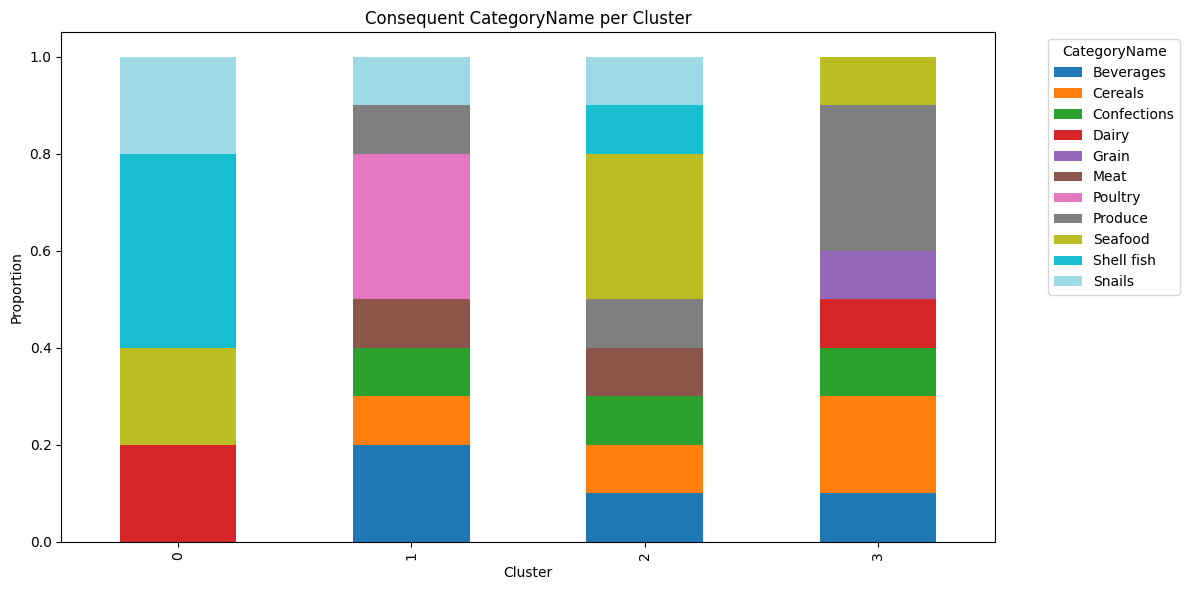

In [ ]:
# Prepare data: only consequents_category
category_df = top_rules_by_lift[["cluster", "consequents_category"]]

# Count and normalize
category_counts = (
    category_df.groupby(["cluster", "consequents_category"])
    .size()
    .unstack(fill_value=0)
)

category_props = category_counts.div(category_counts.sum(axis=1), axis=0)

# Plot
category_props.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="tab20")
plt.title("Consequent CategoryName per Cluster")
plt.ylabel("Proportion")
plt.xlabel("Cluster")
plt.legend(title="CategoryName", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Proportion of Class per Cluster


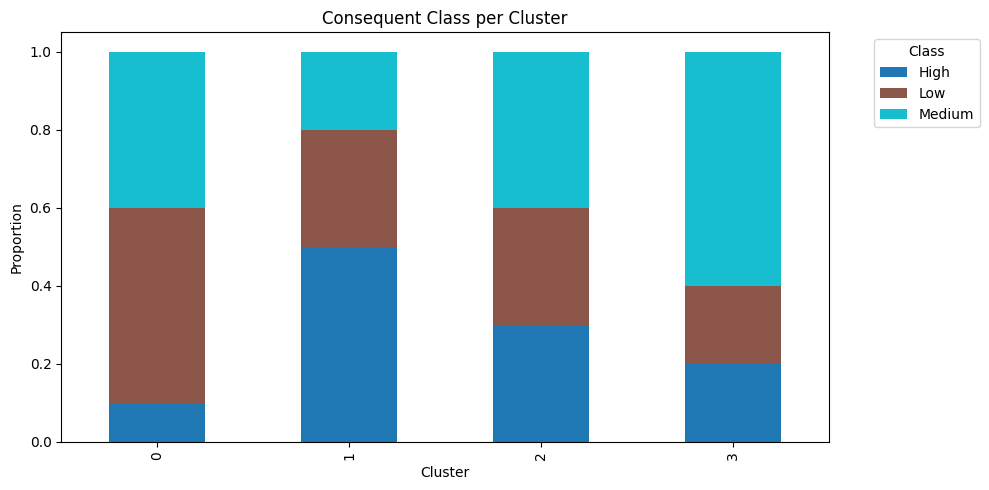

In [ ]:
# Prepare data: only consequents_class
class_df = top_rules_by_lift[["cluster", "consequents_class"]]

# Count and normalize
class_counts = (
    class_df.groupby(["cluster", "consequents_class"]).size().unstack(fill_value=0)
)
class_props = class_counts.div(class_counts.sum(axis=1), axis=0)

# Plot
class_props.plot(kind="bar", stacked=True, figsize=(10, 5), colormap="tab10")
plt.title("Consequent Class per Cluster")
plt.ylabel("Proportion")
plt.xlabel("Cluster")
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Distribution of Rule Strength (Confidence & Lift)


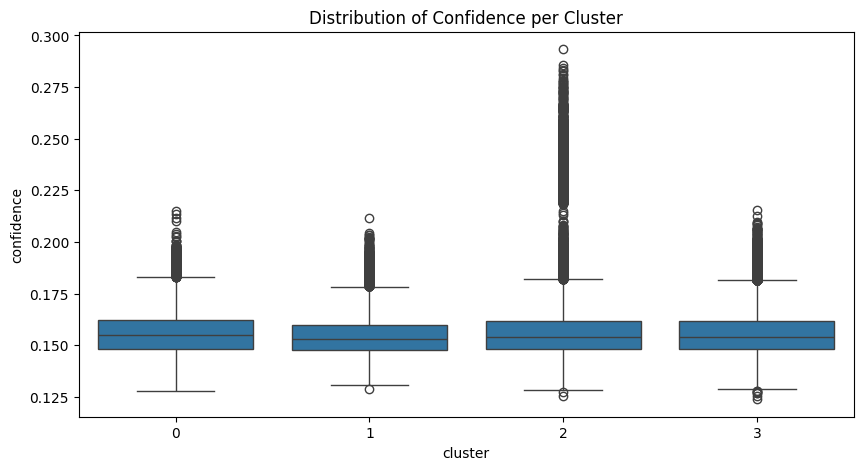

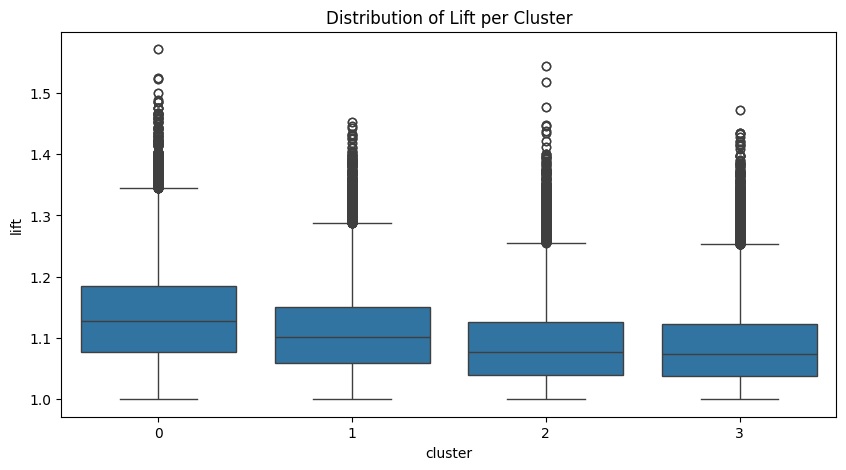

In [ ]:
# Boxplot for confidence
plt.figure(figsize=(10, 5))
sns.boxplot(data=result_rules, x="cluster", y="confidence")
plt.title("Distribution of Confidence per Cluster")
plt.show()

# Boxplot for lift
plt.figure(figsize=(10, 5))
sns.boxplot(data=result_rules, x="cluster", y="lift")
plt.title("Distribution of Lift per Cluster")
plt.show()

# Most Common Consequents Per Cluster


In [ ]:
# Convert frozensets to strings for readability
result_rules["consequents_str"] = result_rules["consequents"].apply(
    lambda x: ", ".join(list(x))
)

top_consequents = (
    result_rules.groupby(["cluster", "consequents_str"])
    .size()
    .reset_index(name="count")
    .sort_values(["cluster", "count"], ascending=[True, False])
    .groupby("cluster")
    .head(5)
    .reset_index(drop=True)
)

top_consequents

,cluster,consequents_str,count
0,0,"Soup - Campbells, Beef Barley",203
1,0,Yogurt - French Vanilla,188
2,0,Pork - Kidney,186
3,0,Campari,182
4,0,Grouper - Fresh,179
5,1,Pears - Bosc,238
6,1,Veal - Osso Bucco,227
7,1,Cheese - Victor Et Berthold,226
8,1,"Thyme - Lemon, Fresh",226
9,1,Nantucket - Pomegranate Pear,225


# Top Antecedents Per Cluster


In [ ]:
result_rules["antecedents_str"] = result_rules["antecedents"].apply(
    lambda x: ", ".join(list(x))
)

top_antecedents = (
    result_rules.groupby(["cluster", "antecedents_str"])
    .size()
    .reset_index(name="count")
    .sort_values(["cluster", "count"], ascending=[True, False])
    .groupby("cluster")
    .head(5)
    .reset_index(drop=True)
)

top_antecedents

,cluster,antecedents_str,count
0,0,"Soup - Campbells, Beef Barley",203
1,0,Yogurt - French Vanilla,188
2,0,Pork - Kidney,186
3,0,Campari,182
4,0,Grouper - Fresh,179
5,1,Pears - Bosc,238
6,1,Veal - Osso Bucco,227
7,1,Cheese - Victor Et Berthold,226
8,1,"Thyme - Lemon, Fresh",226
9,1,Nantucket - Pomegranate Pear,225


# Scatter Plot of Confidence vs Lift (Per Cluster)


<Figure size 1200x600 with 0 Axes>

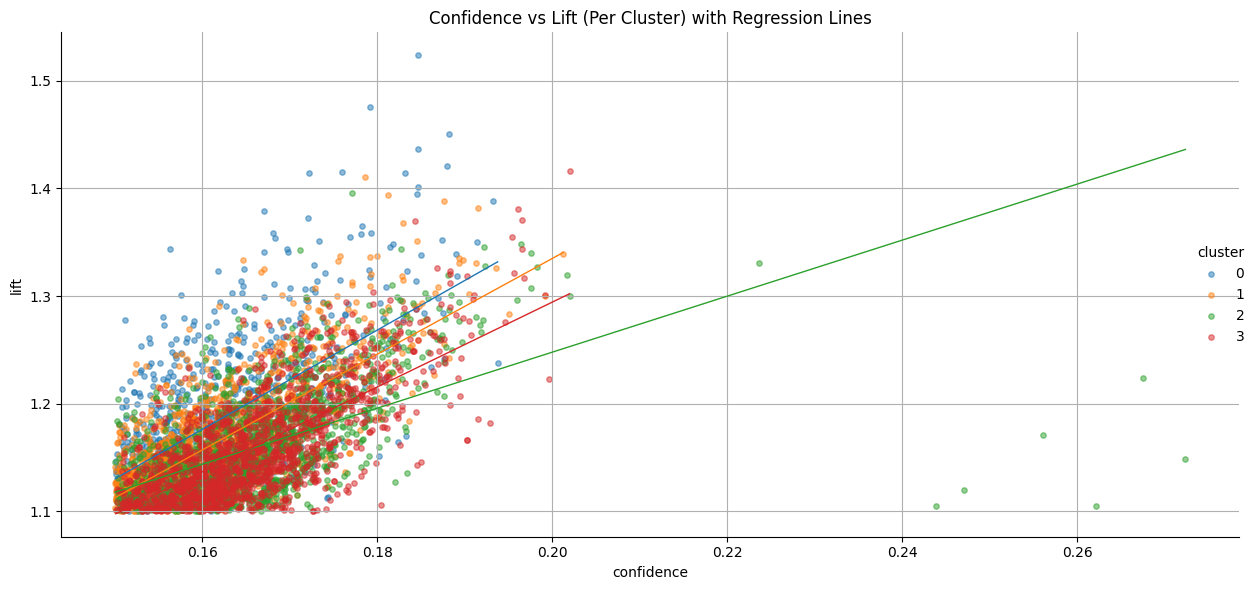

In [ ]:
sampled_rules = (
    result_rules[(result_rules["confidence"] > 0.15) & (result_rules["lift"] > 1.1)]
    .groupby("cluster")
    .sample(frac=0.05, random_state=42)
)

plt.figure(figsize=(12, 6))
sns.lmplot(
    data=sampled_rules,
    x="confidence",
    y="lift",
    hue="cluster",
    palette="tab10",
    scatter_kws={"alpha": 0.5, "s": 15},
    line_kws={"linewidth": 1},
    height=6,
    aspect=2,
    ci=None,
)

plt.title("Confidence vs Lift (Per Cluster) with Regression Lines")
plt.grid(True)
plt.tight_layout()
plt.show()

# Number of Rules per Cluster


<Axes: title={'center': 'Number of Rules per Cluster'}, xlabel='cluster'>

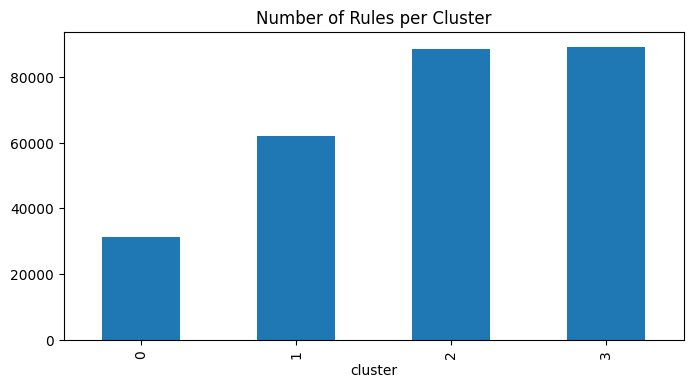

In [ ]:
rules_per_cluster = result_rules["cluster"].value_counts().sort_index()
rules_per_cluster.plot(kind="bar", figsize=(8, 4), title="Number of Rules per Cluster")

# Summary Table per Cluster


In [ ]:
summary = (
    result_rules.groupby("cluster")
    .agg(
        num_rules=("antecedents", "count"),
        avg_confidence=("confidence", "mean"),
        avg_lift=("lift", "mean"),
        max_lift=("lift", "max"),
        max_confidence=("confidence", "max"),
    )
    .reset_index()
)

summary

,cluster,num_rules,avg_confidence,avg_lift,max_lift,max_confidence
0,0,31270,0.155835,1.136387,1.571425,0.214953
1,1,62014,0.154510,1.109832,1.452561,0.211494
2,2,88666,0.156332,1.088441,1.544410,0.293307
3,3,89316,0.155710,1.086786,1.471721,0.215292
